# Прогнозирование музыкального жанра

**Описание полей данных**
- `instance_id` - уникальный идентификатор трека
- `track_name` - название трека
- `acousticness` - акустичность
- `danceability` - танцевальность
- `duration_ms` -продолжительность в милисекундах
- `energy` - энергичность
- `instrumentalness` - инструментальность
- `key` - базовый ключ (нота) произведения
- `liveness` - привлекательность
- `loudness` - громкость
- `mode` - указывает на модальность (мажорную или минорную) трека
- `speechiness` - выразительность
- `tempo` - темп
- `obtained_date` - дата загрузки в сервис
- `valence` - привлекательность произведения для пользователей сервиса
- `music_genre` - музыкальный жанр

## Данные

### Импорты

In [345]:
%pip install sweetviz
%pip install scikit-learn==1.1.3
%pip install catboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [346]:
import pandas as pd
import sweetviz as sv
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import *

from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
from sklearn.utils import shuffle

from tqdm import tqdm
import matplotlib.pyplot as plt

In [347]:
train_data = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Music_genre_classification/Data/kaggle_music_genre_train.csv')
test_data = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Music_genre_classification/Data/kaggle_music_genre_test.csv')

submit_test = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Music_genre_classification/Data/sample_submit.csv')

### Обзор данных

Напишем функцию для простого EDA

In [348]:
def info_df(df):
    plt.figure(figsize=(15, 13))
    sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
    print('------------------------------')
    print('| Информация о наборе данных |')
    print('------------------------------')
    df.info()
    print('------------------------------')
    print('| Первые 10 строчек датасета |')
    print('------------------------------')
    print(df.head(10))
    print('---------------------------------')
    print('| Последние 10 строчек датасета |')
    print('---------------------------------')
    print(df.tail(10))
    print('---------------------------')
    print('| Описательная статистика |')
    print('---------------------------')
    print(df.describe())
    print('--------------------')
    print('| Сумма дубликатов |')
    print('--------------------')
    print(df.duplicated().sum())
    print('--------------------------')
    print('| Ковариационная матрица |')
    print('--------------------------')
    plt.show()

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_4353/2409429548.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



        instance_id  acousticness  danceability   duration_ms        energy  \
count  20394.000000  20394.000000  20394.000000  2.039400e+04  20394.000000   
mean   55973.846916      0.274783      0.561983  2.203754e+05      0.625276   
std    20695.792545      0.321643      0.171898  1.267283e+05      0.251238   
min    20011.000000      0.000000      0.060000 -1.000000e+00      0.001010   
25%    38157.250000      0.015200      0.451000  1.775170e+05      0.470000   
50%    56030.000000      0.120000      0.570000  2.195330e+05      0.666000   
75%    73912.750000      0.470000      0.683000  2.660000e+05      0.830000   
max    91758.000000      0.996000      0.978000  4.497994e+06      0.999000   

       instrumentalness      liveness      loudness   speechiness  \
count      20394.000000  20394.000000  20394.000000  20394.000000   
mean           0.159989      0.198540     -8.552998      0.091352   
std            0.306503      0.166742      5.499917      0.097735   
min         

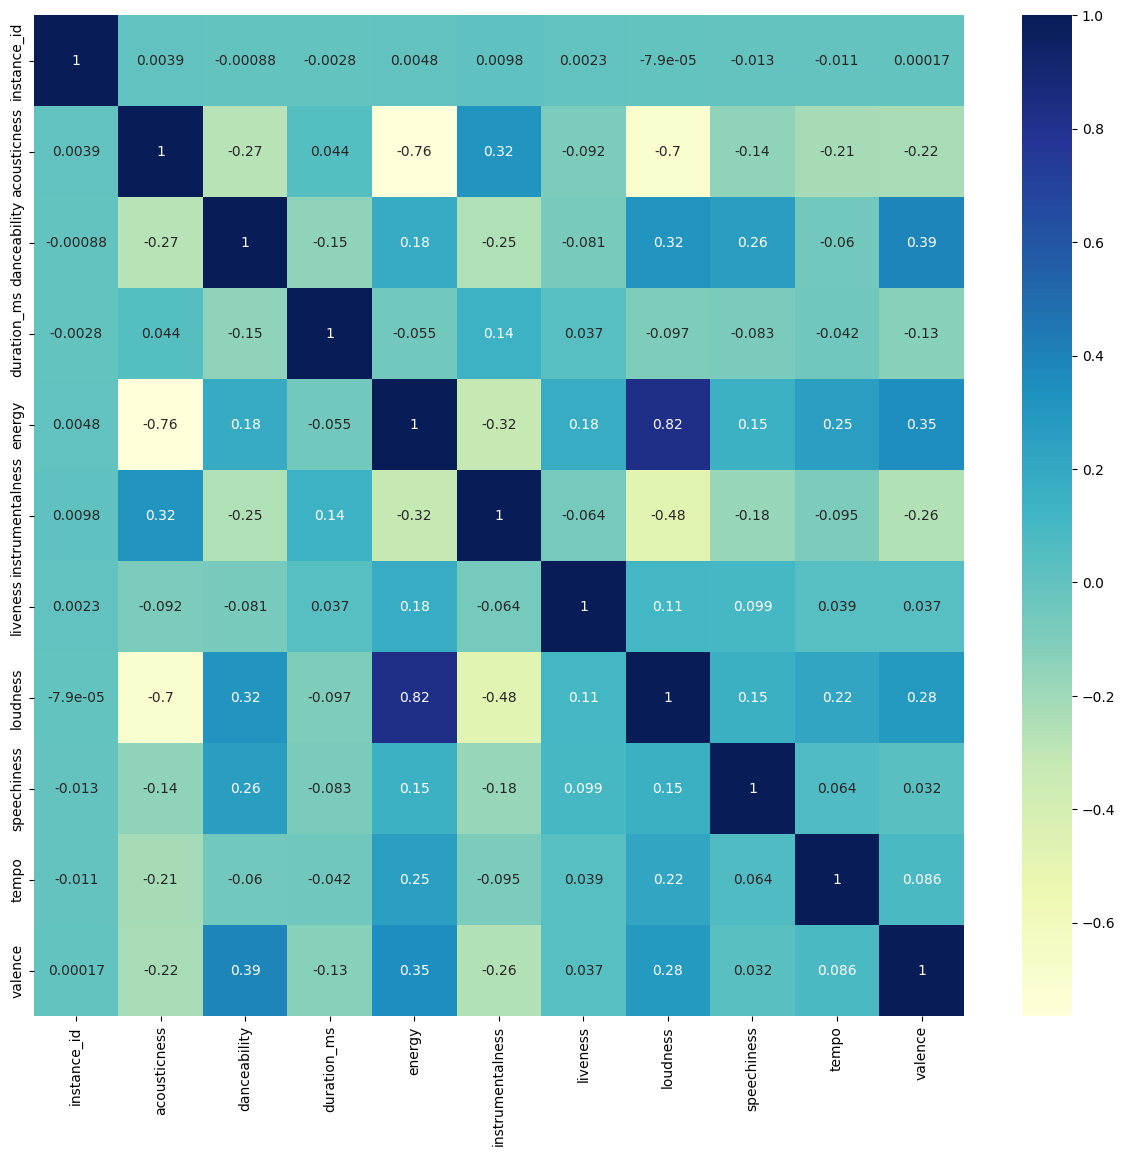

In [349]:
info_df(train_data)

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_4353/2409429548.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
d

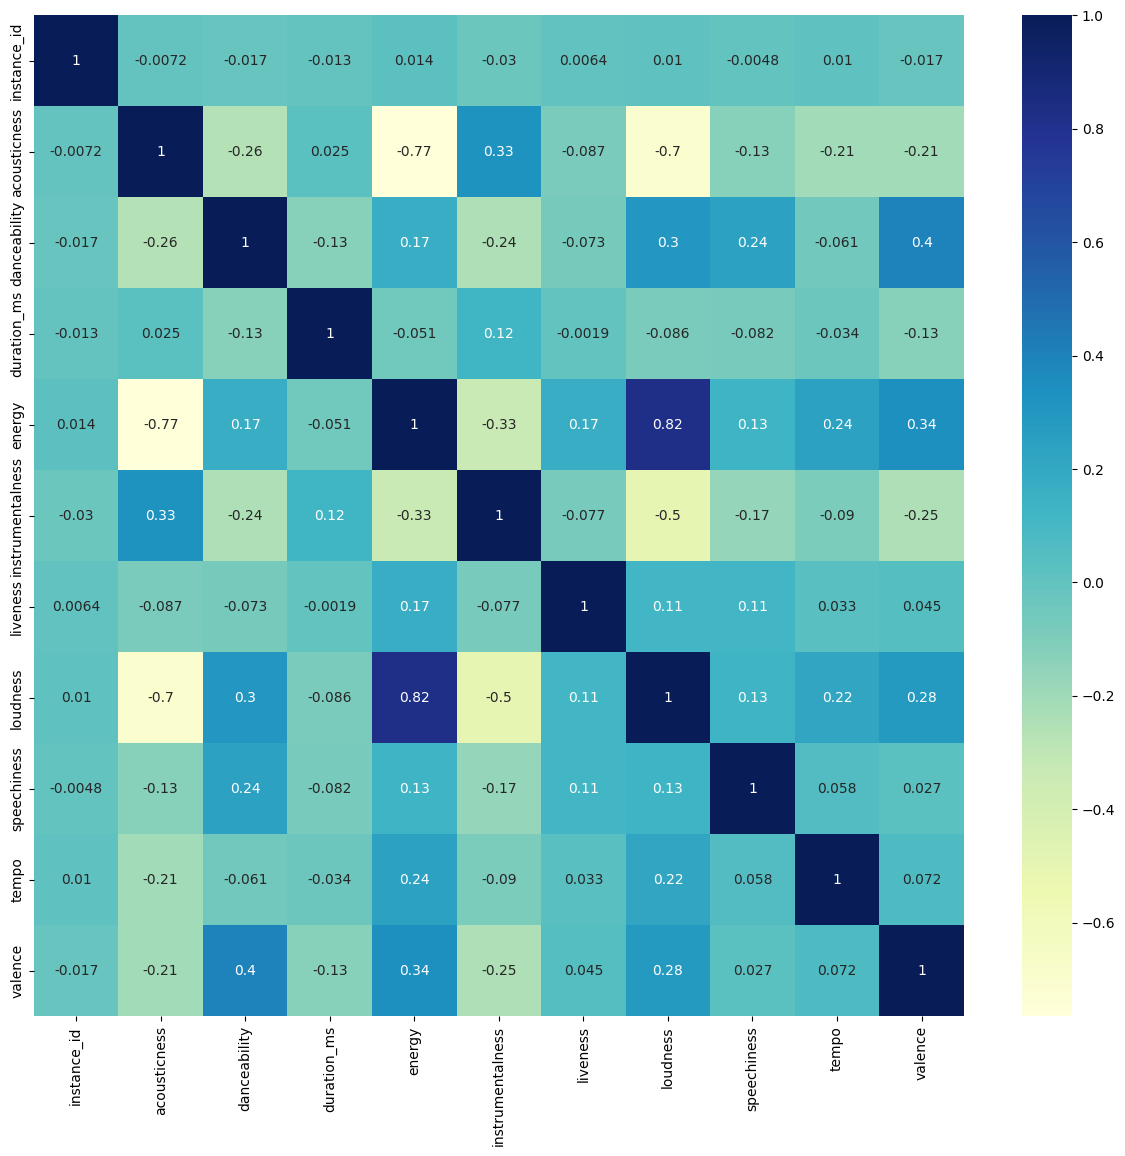

In [350]:
info_df(test_data)

Посмотрим на соотношение пропусков данных

In [351]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
instance_id,0.000000
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.600000
liveness,0.000000
loudness,0.000000


In [352]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(test_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
instance_id,0.000000
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.100000
liveness,0.000000
loudness,0.000000


### Константы

In [353]:
RANDOM_STATE = 1220

## Предобработка и исследовательский анализ данных

### Приведение типов данных

#### Явные и неявные дубликаты

Проверим наличие явных дубликатов

In [354]:
train_data = train_data.drop('instance_id',axis=1)
train_data.duplicated().sum()

1

In [355]:
test_data = test_data.drop('instance_id',axis=1)
test_data.duplicated().sum()

30

In [356]:
train_data = train_data.drop_duplicates().reset_index(drop=True)
# Удалять дубликаты мы не будем, дабы соблюсти размер датасета для проверки
# test_data = test_data.drop_duplicates().reset_index(drop=True)

Рассмотрим наличие неявных дубликатов

In [357]:
for i in ['key', 'mode', 'obtained_date', 'music_genre']:
    print(i)
    print('------------------------------------------------------------')
    print(train_data[i].unique())
    print('------------------------------------------------------------')

key
------------------------------------------------------------
['D' 'A' 'E' 'G#' 'C' 'D#' 'A#' 'F' 'F#' nan 'G' 'C#' 'B']
------------------------------------------------------------
mode
------------------------------------------------------------
['Major' 'Minor' nan]
------------------------------------------------------------
obtained_date
------------------------------------------------------------
['4-Apr' '3-Apr' '5-Apr' '1-Apr']
------------------------------------------------------------
music_genre
------------------------------------------------------------
['Country' 'Rock' 'Alternative' 'Hip-Hop' 'Blues' 'Jazz' 'Electronic'
 'Anime' 'Rap' 'Classical']
------------------------------------------------------------


In [358]:
for i in ['key', 'mode', 'obtained_date']:
    print(i)
    print('------------------------------------------------------------')
    print(test_data[i].unique())
    print('------------------------------------------------------------')

key
------------------------------------------------------------
['A#' 'G#' 'A' 'B' 'D' 'F#' 'F' 'G' 'C' nan 'D#' 'C#' 'E']
------------------------------------------------------------
mode
------------------------------------------------------------
['Minor' 'Major' nan]
------------------------------------------------------------
obtained_date
------------------------------------------------------------
['4-Apr' '3-Apr' '5-Apr' '1-Apr']
------------------------------------------------------------


#### Преобразование вещественных типов данных

In [359]:
train_data['duration_ms'] = train_data['duration_ms'].astype('int32')

test_data['duration_ms'] = test_data['duration_ms'].astype('int32')

#### Поиск аномальных значений

Взглянем еще раз на данные нашего тренировачного датасета

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20393 entries, 0 to 20392
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        20393 non-null  object 
 1   acousticness      20393 non-null  float64
 2   danceability      20393 non-null  float64
 3   duration_ms       20393 non-null  int32  
 4   energy            20393 non-null  float64
 5   instrumentalness  20393 non-null  float64
 6   key               19658 non-null  object 
 7   liveness          20393 non-null  float64
 8   loudness          20393 non-null  float64
 9   mode              19887 non-null  object 
 10  speechiness       20393 non-null  float64
 11  tempo             19951 non-null  float64
 12  obtained_date     20393 non-null  object 
 13  valence           20393 non-null  float64
 14  music_genre       20393 non-null  object 

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_4353/2409429548.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



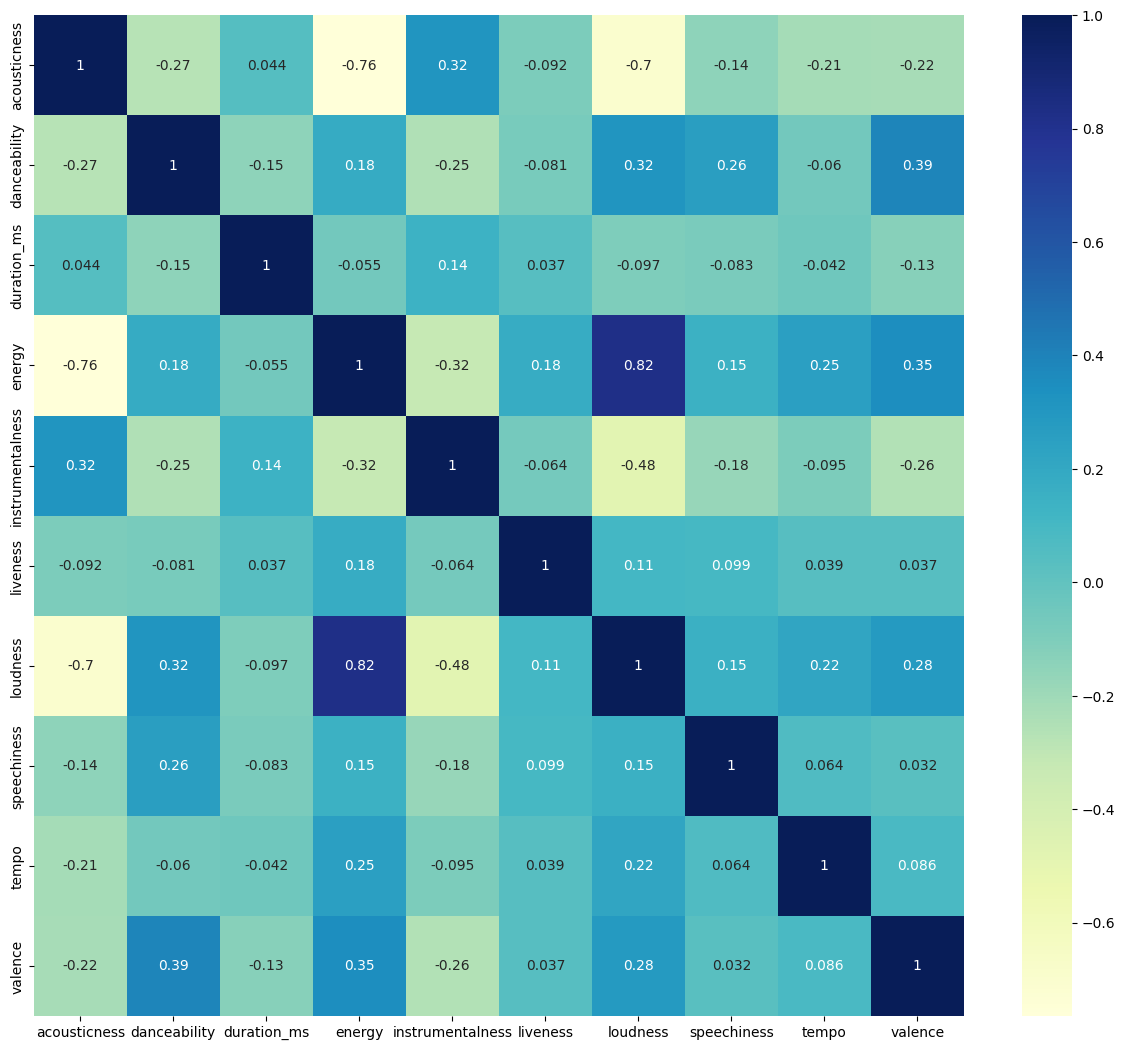

In [360]:
info_df(train_data)

Обратим внимание на длительность некоторых треков в -1 миллисекунду. Вариантов несколько: можно удалить все треки которые имеют такое значение и потерять кусочек данных, можно заменить медианным значением всех треков, а можно оставить как есть и перед обучением модели (после масштабирования признаков) занизить это значение, дабы оно не влияло на обучение

**Длительность трека**

Оценим экстремумы треков в датасете

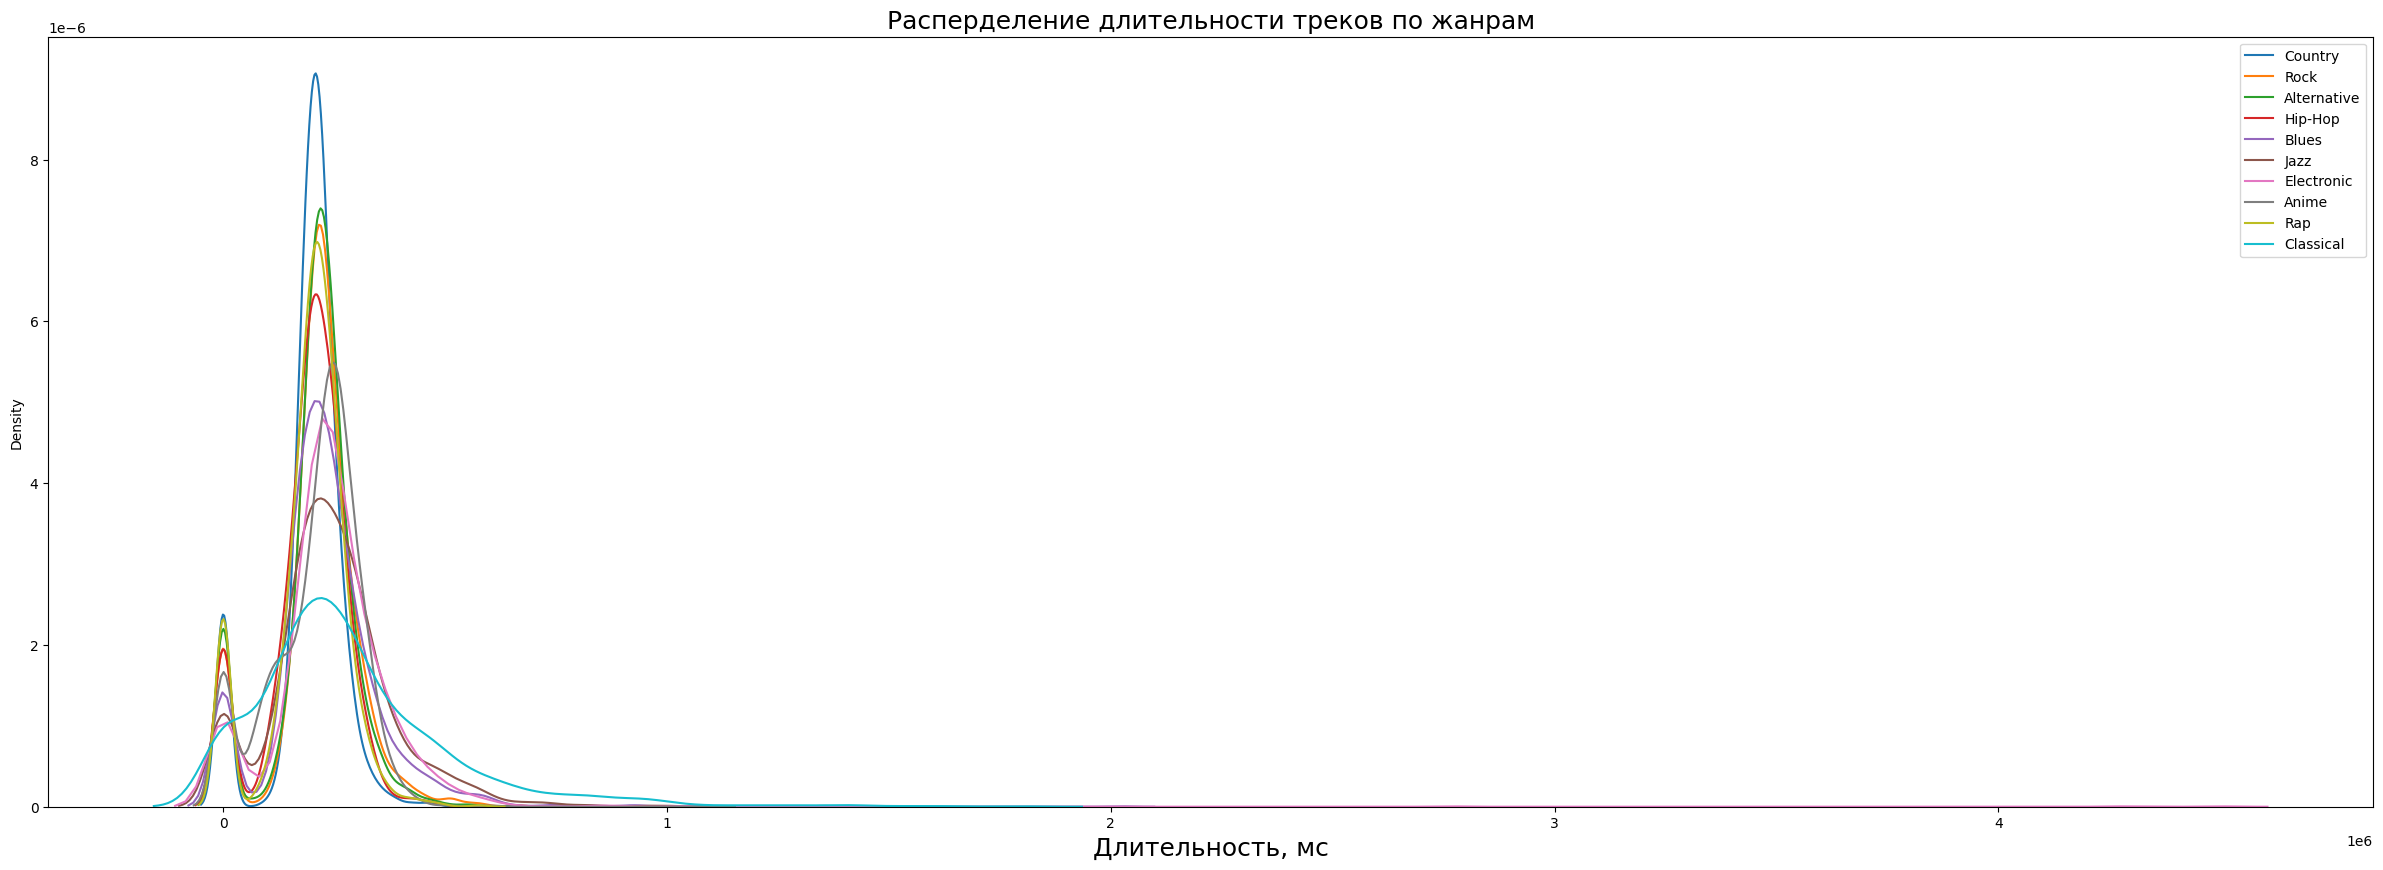

In [361]:
plt.figure(figsize=(30,10))
for genre in train_data['music_genre'].unique():
    sb.kdeplot(data=train_data.loc[train_data['music_genre']==genre, 'duration_ms'], label=genre)

plt.title("Расперделение длительности треков по жанрам", fontsize = 18)

plt.xlabel("Длительность, мс", fontsize = 18)
plt.legend();

Видно, что данные имеют аномальные значения. Особенно это видно на максимальной длительности трека. Возьмем ограничения в 2 стандартных отклонения

In [362]:
print((train_data.loc[train_data['duration_ms'] 
                < train_data['duration_ms']
               .std() * 0.95]
               .groupby('music_genre')['track_name']
               .agg({'count'})))

print('Всего треков:', (train_data.loc[train_data['duration_ms'] 
                < train_data['duration_ms']
               .std() * 0.95, 'track_name']
               .count()))

             count
music_genre       
Alternative    303
Anime          352
Blues          302
Classical      249
Country        218
Electronic     289
Hip-Hop        165
Jazz           154
Rap            316
Rock           234
Всего треков: 2582


Наибольшее количество коротких треков относится к жанрам:
- `Anime`
- `Rap`
- `Alternative`

In [363]:
print((train_data.loc[train_data['duration_ms'] 
                > train_data['duration_ms']
               .std() * 2]
               .groupby('music_genre')['track_name']
               .agg('count')))
print('Всего треков:', (train_data.loc[train_data['duration_ms'] 
                > train_data['duration_ms']
               .std() * 2, 'track_name']
               .count()))

music_genre
Alternative     672
Anime           693
Blues           987
Classical       654
Country         320
Electronic     1025
Hip-Hop         246
Jazz            533
Rap             484
Rock            607
Name: track_name, dtype: int64
Всего треков: 6221


А наибольшее количество долгих треков относится к жанрам:
- `Electronic`
- `Blues`
- `Anime`

Отберем только те треки длительность которых укладывается в заданый нами интервал и оценим расспределение длительности треков по жанрам

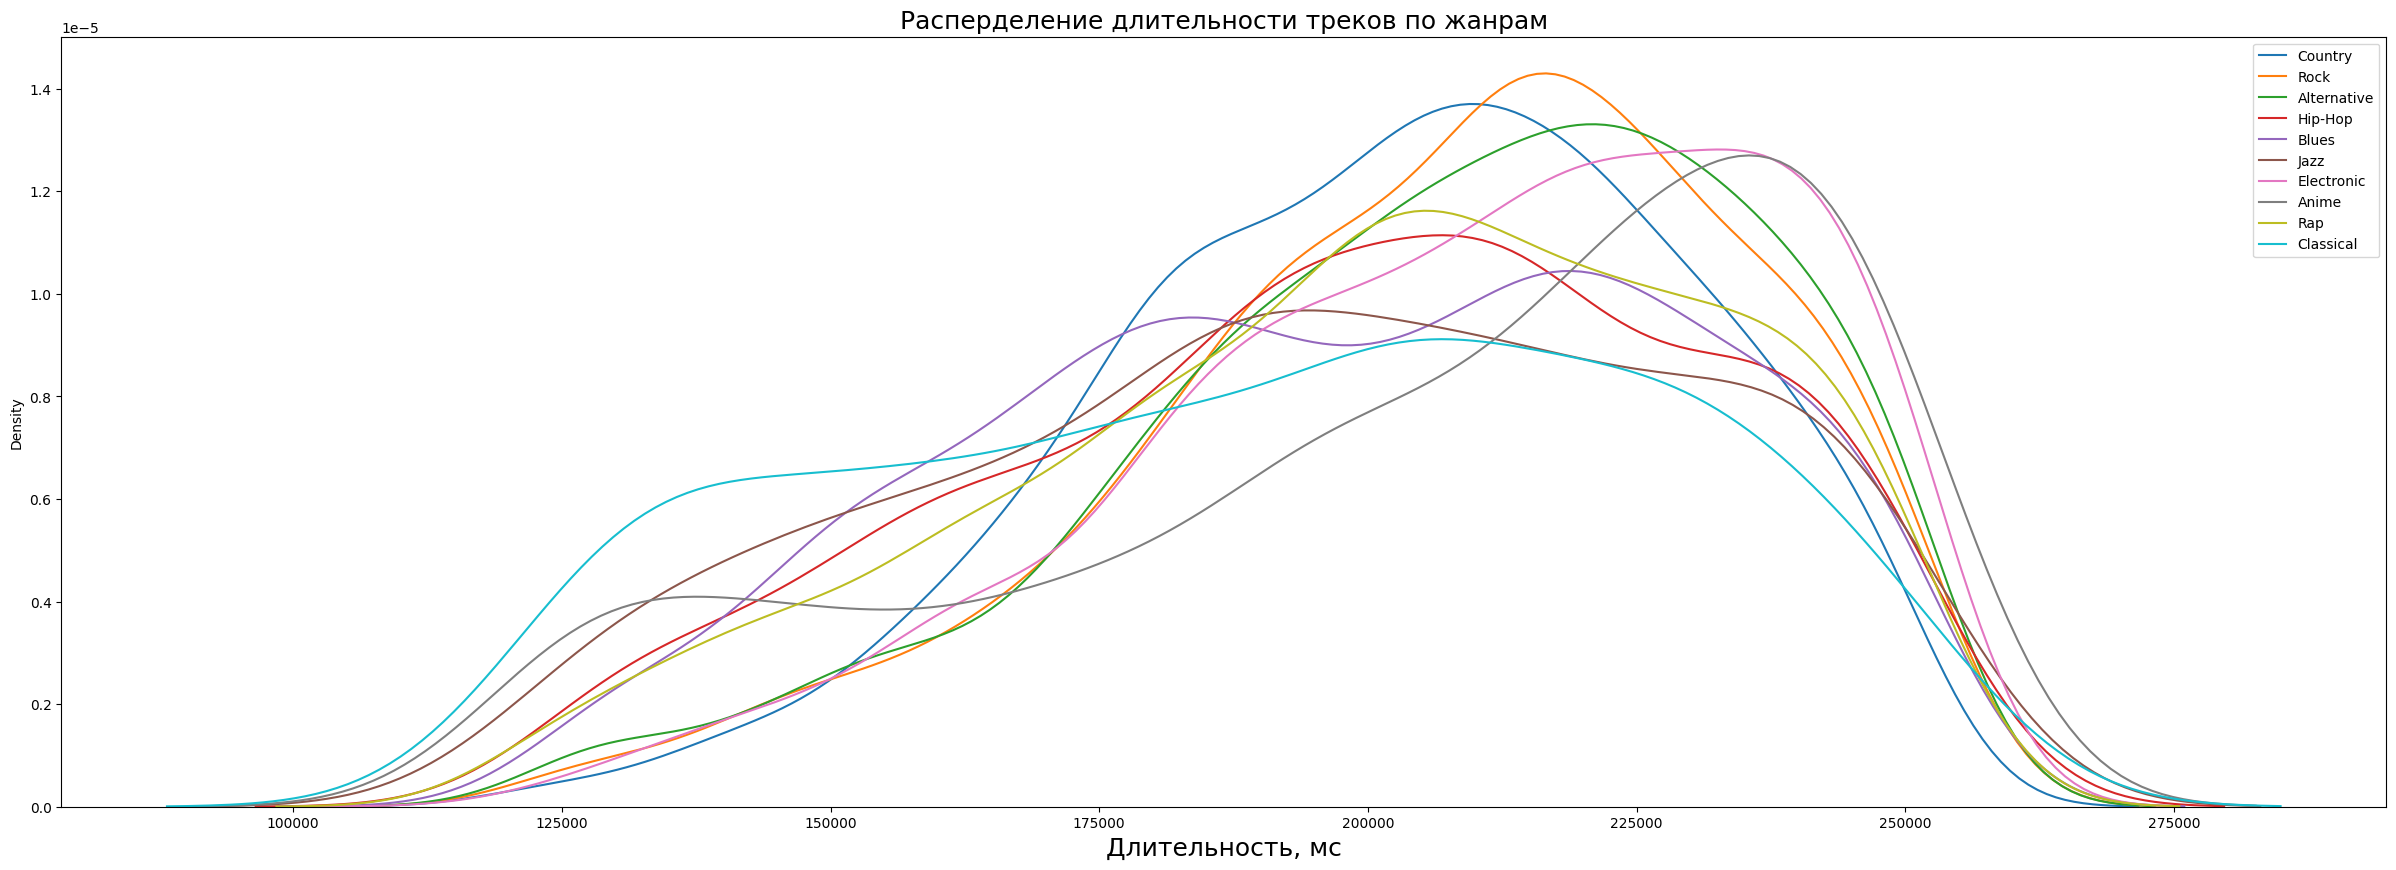

In [364]:
plt.figure(figsize=(30,10))
for genre in train_data['music_genre'].unique():
    sb.kdeplot(data=train_data.loc[(train_data['music_genre']==genre) & 
                                   ((train_data['duration_ms'] > train_data['duration_ms'].std() * 0.95) & 
                                    (train_data['duration_ms'] < train_data['duration_ms'].std() * 2)), 'duration_ms'], label=genre)

plt.title("Расперделение длительности треков по жанрам", fontsize = 18)

plt.xlabel("Длительность, мс", fontsize = 18)
plt.legend();

Создадим новый признак `duration_class` который будет являтся идентификатором длительности трека (до OHE: short, median, long)

In [365]:
def sml_train_songs(row):
    if row < train_data['duration_ms'].std() * 0.95:
        return 'short'
    elif row > train_data['duration_ms'].std() * 3:
        return 'long'
    else:
        return 'median'

In [366]:
def sml_test_songs(row):
    if row < test_data['duration_ms'].std() * 0.95:
        return 'short'
    elif row > test_data['duration_ms'].std() * 3:
        return 'long'
    else:
        return 'median'

In [367]:
train_data['duration_class'] = train_data['duration_ms'].apply(sml_train_songs)

In [368]:
test_data['duration_class'] = test_data['duration_ms'].apply(sml_test_songs)

**Привлекательность**

Рассмотрим корреляцию между параметрами `liveness` - привлекательность и `valence` - привлекательность произведения для пользователей сервиса.


In [369]:
train_data.corr()

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_4353/1402113604.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
acousticness,1.000000,-0.273419,0.043785,-0.764948,0.316764,-0.091838,-0.699720,-0.144584,-0.214752,-0.221685
danceability,-0.273419,1.000000,-0.145351,0.182731,-0.253840,-0.080751,0.317235,0.257981,-0.059774,0.390221
duration_ms,0.043785,-0.145351,1.000000,-0.055474,0.141535,0.037051,-0.096944,-0.082700,-0.041716,-0.126994
energy,-0.764948,0.182731,-0.055474,1.000000,-0.319967,0.176772,0.821804,0.150509,0.250642,0.347975
instrumentalness,0.316764,-0.253840,0.141535,-0.319967,1.000000,-0.063751,-0.481398,-0.176946,-0.095373,-0.259975
liveness,-0.091838,-0.080751,0.037051,0.176772,-0.063751,1.000000,0.106565,0.098574,0.038922,0.037184
loudness,-0.699720,0.317235,-0.096944,0.821804,-0.481398,0.106565,1.000000,0.152087,0.220497,0.284014
speechiness,-0.144584,0.257981,-0.082700,0.150509,-0.176946,0.098574,0.152087,1.000000,0.064399,0.031584
tempo,-0.214752,-0.059774,-0.041716,0.250642,-0.095373,0.038922,0.220497,0.064399,1.000000,0.085628
valence,-0.221685,0.390221,-0.126994,0.347975,-0.259975,0.037184,0.284014,0.031584,0.085628,1.000000


Линейной зависимости от этих двух параметров не наблюдается. Оставим оба этих параметра и выберем наилучший путем рассчета значения Шэпли.

**Темп**

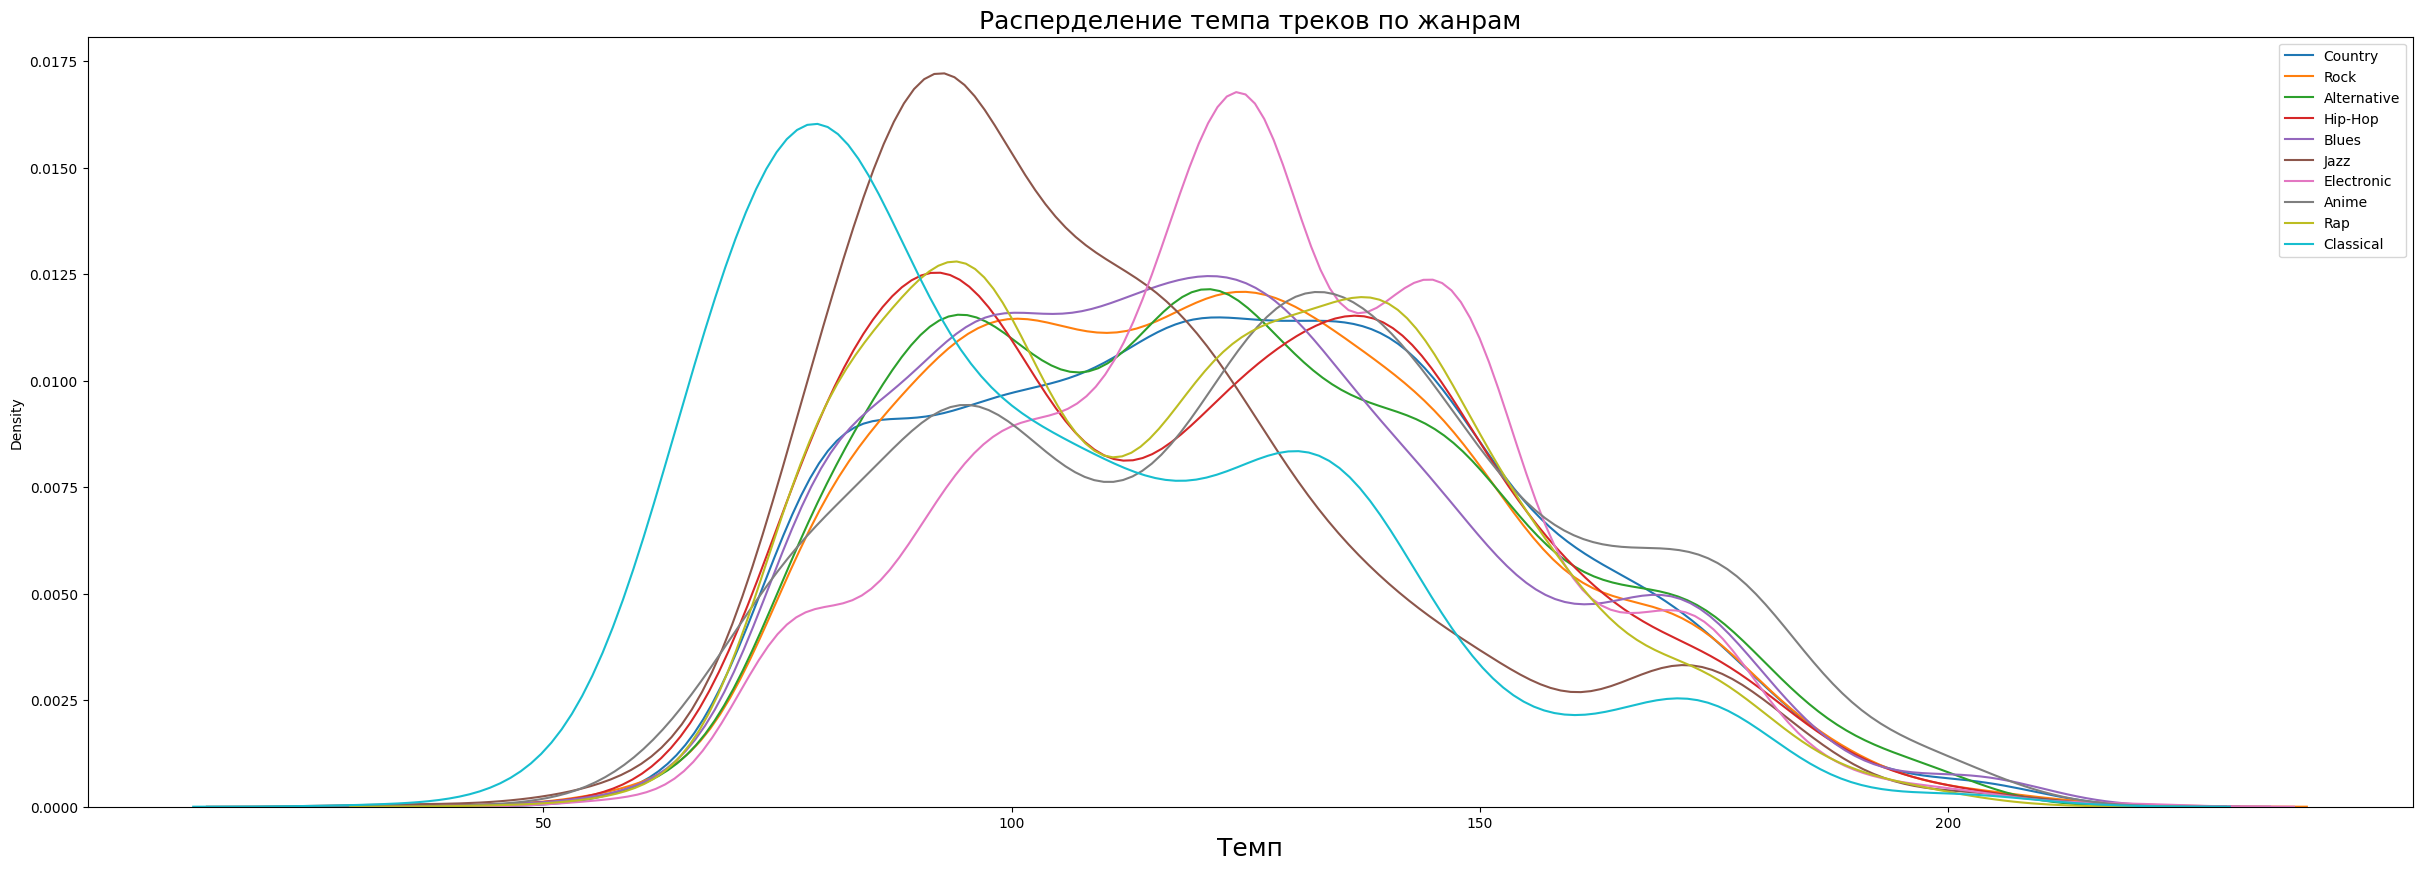

In [370]:
plt.figure(figsize=(30,10))
for genre in train_data['music_genre'].unique():
    sb.kdeplot(data=train_data.loc[(train_data['music_genre']==genre), 'tempo'], label=genre)

plt.title("Расперделение темпа треков по жанрам", fontsize = 18)

plt.xlabel("Темп", fontsize = 18)
plt.legend();

Можно отметить что для жанров Классической музыки, Джаза и Электронной  характерен высокий темп исполнения. Для заполнения пропусков в параметре Темп разделим медианное значение жанров Классика, Джаз, Электронная и оставшиеся жанры.

In [371]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.600000
liveness,0.000000
loudness,0.000000
mode,2.500000


In [372]:
train_data.loc[(train_data['music_genre']=='Classical') & (train_data['tempo'].isna() == True), 'tempo'] = \
train_data.loc[(train_data['music_genre']=='Classical') & (train_data['tempo'].isna() == False), 'tempo'].median()

In [373]:
train_data.loc[(train_data['music_genre']=='Jazz') & (train_data['tempo'].isna() == True), 'tempo'] = \
train_data.loc[(train_data['music_genre']=='Jazz') & (train_data['tempo'].isna() == False), 'tempo'].median()

In [374]:
train_data.loc[(train_data['music_genre']=='Electronic') & (train_data['tempo'].isna() == True), 'tempo'] = \
train_data.loc[(train_data['music_genre']=='Electronic') & (train_data['tempo'].isna() == False), 'tempo'].median()

In [375]:
train_data.loc[(train_data['tempo'].isna() == True), 'tempo'] = \
train_data.loc[(train_data['tempo'].isna() == False), 'tempo'].median()

test_data.loc[(test_data['tempo'].isna() == True), 'tempo'] = \
test_data.loc[(test_data['tempo'].isna() == False), 'tempo'].median()

In [376]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.600000
liveness,0.000000
loudness,0.000000
mode,2.500000


In [377]:
train_data.head()

,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,duration_class
0,Highwayman,0.4800,0.670,182653,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country,median
1,Toes Across The Floor,0.2430,0.452,187133,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock,median
2,First Person on Earth,0.2280,0.454,173448,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative,median
3,No Te Veo - Digital Single,0.0558,0.847,255987,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop,median
4,Chasing Shadows,0.2270,0.742,195333,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative,median


# Подготовка признаков

Исследуем четыре модели `DecisionTreeClassifier`, `RandomForestClassifier`, `LogisticRegression` и `CatBoost`. 

In [378]:
train_data = train_data.drop(['track_name', 'obtained_date', 'duration_ms'], axis=1)
test_data = test_data.drop(['track_name', 'obtained_date', 'duration_ms'], axis = 1)

In [379]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
acousticness,0.000000
danceability,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.600000
liveness,0.000000
loudness,0.000000
mode,2.500000
speechiness,0.000000
tempo,0.000000


In [380]:
train_data['key'] = train_data.loc[train_data['key'].isna(), 'key'] = 'N'
train_data['mode'] = train_data.loc[train_data['mode'].isna(), 'mode'] = 'N'

test_data['key'] = test_data.loc[test_data['key'].isna(), 'key'] = 'N'
test_data['mode'] = test_data.loc[test_data['mode'].isna(), 'mode'] = 'N'

# train_data = train_data.dropna()
# test_data = test_data.dropna()

In [381]:
features = train_data.drop(['music_genre'], axis = 1)
target = train_data['music_genre']

test_features = test_data
test_target = submit_test['music_genre']



# train_data = train_data.fillna(-999)
# test_features = test_features.fillna(-999)


In [382]:
ohe_features = features.select_dtypes(include='object').columns.to_list()
print(ohe_features)
num_features = features.select_dtypes(exclude='object').columns.to_list()
num_features

['key', 'mode', 'duration_class']


['acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence']

In [383]:
# num_w_dur = ['acousticness',
#              'danceability',
#  'energy',
#  'instrumentalness',
#  'liveness',
#  'loudness',
#  'speechiness',
#  'tempo',
#  'valence']

In [384]:
# features[num_w_dur] = features[num_w_dur] * 100000
# test_features[num_w_dur] = test_features[num_w_dur] * 100000

In [385]:
# features[num_features] = features[num_features].astype('int')
# test_features[num_features] = test_features[num_features].astype('int')

In [386]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(features[ohe_features])

features[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features[ohe_features])

features = features.drop(ohe_features, axis=1)

In [387]:
test_features[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(test_features[ohe_features])

test_features = test_features.drop(ohe_features, axis=1)

In [388]:
# scaler = StandardScaler()
# features[num_features] = scaler.fit_transform(features[num_features])

# scaler.fit(pd.DataFrame(features[num_features]))

In [389]:
# features[num_features] = scaler.transform(features[num_features])
# test_features[num_features] = scaler.transform(test_features[num_features])

In [390]:
# features = features.astype('int')
# test_features = test_features.astype('int')

In [391]:
features

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_class_median,duration_class_short
0,0.48000,0.670,0.351,0.017600,0.1150,-16.842,0.0463,101.384,0.450,1.0,0.0
1,0.24300,0.452,0.670,0.000051,0.1080,-8.392,0.0352,113.071,0.539,1.0,0.0
2,0.22800,0.454,0.804,0.000000,0.1810,-5.225,0.3710,80.980,0.344,1.0,0.0
3,0.05580,0.847,0.873,0.000003,0.3250,-4.805,0.0804,116.007,0.966,1.0,0.0
4,0.22700,0.742,0.575,0.000002,0.1760,-5.550,0.0487,76.494,0.583,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
20388,0.71900,0.725,0.483,0.000000,0.0797,-13.314,0.0438,87.413,0.942,0.0,1.0
20389,0.19000,0.482,0.362,0.005620,0.0913,-10.358,0.0299,76.879,0.174,1.0,0.0
20390,0.00061,0.663,0.886,0.000025,0.2840,-4.149,0.0358,146.803,0.942,1.0,0.0
20391,0.00310,0.914,0.515,0.000000,0.1050,-9.934,0.3560,150.016,0.215,1.0,0.0


In [335]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

cat_features = list(range(0, features.shape[1]))
cat_transformer = Pipeline(steps=[('imputer', IterativeImputer(random_state=RANDOM_STATE)),
                                  ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[
    ('num', cat_transformer, cat_features)
])

In [226]:
# features_train, features_valid, target_train, target_valid \
# = train_test_split(features, target, random_state=RANDOM_STATE, test_size=0.2, 
#                    stratify=target, shuffle=True)

In [273]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', CatBoostClassifier(loss_function='MultiClass',
                                                          iterations=3000,
                                                          depth=10,
                                                          learning_rate=0.5,
                                                          random_state=RANDOM_STATE))]).fit(features, 
                                                                                            target)

Learning rate set to 0.03647
0:	learn: 2.2574501	total: 109ms	remaining: 5m 27s
1:	learn: 2.2146152	total: 235ms	remaining: 5m 51s
2:	learn: 2.1763511	total: 281ms	remaining: 4m 40s
3:	learn: 2.1392632	total: 324ms	remaining: 4m 2s
4:	learn: 2.1037087	total: 367ms	remaining: 3m 39s
5:	learn: 2.0744037	total: 409ms	remaining: 3m 24s
6:	learn: 2.0460925	total: 452ms	remaining: 3m 13s
7:	learn: 2.0188437	total: 492ms	remaining: 3m 4s
8:	learn: 1.9940237	total: 535ms	remaining: 2m 57s
9:	learn: 1.9700149	total: 580ms	remaining: 2m 53s
10:	learn: 1.9494196	total: 623ms	remaining: 2m 49s
11:	learn: 1.9282102	total: 667ms	remaining: 2m 45s
12:	learn: 1.9091041	total: 710ms	remaining: 2m 43s
13:	learn: 1.8899578	total: 750ms	remaining: 2m 39s
14:	learn: 1.8720799	total: 791ms	remaining: 2m 37s
15:	learn: 1.8559478	total: 832ms	remaining: 2m 35s
16:	learn: 1.8388048	total: 875ms	remaining: 2m 33s
17:	learn: 1.8236003	total: 921ms	remaining: 2m 32s
18:	learn: 1.8092090	total: 964ms	remaining: 2m

In [340]:
model.score(features_train, target_train)

0.9728143946802269

In [343]:
features = features.abs()

In [397]:
from sklearn.feature_selection import SelectPercentile, chi2

selection = SelectPercentile(chi2, percentile=50)

preprocessor = ColumnTransformer(transformers=[
    ('num',selection, cat_transformer, cat_features)
])
cross_val_score(model, features, target, cv=5, scoring='accuracy').mean()


Learning rate set to 0.036058
0:	learn: 2.2586179	total: 124ms	remaining: 6m 10s
1:	learn: 2.2202637	total: 207ms	remaining: 5m 9s
2:	learn: 2.1830330	total: 255ms	remaining: 4m 14s
3:	learn: 2.1471376	total: 295ms	remaining: 3m 41s
4:	learn: 2.1122286	total: 336ms	remaining: 3m 21s
5:	learn: 2.0832633	total: 376ms	remaining: 3m 7s
6:	learn: 2.0538098	total: 418ms	remaining: 2m 58s
7:	learn: 2.0270543	total: 461ms	remaining: 2m 52s
8:	learn: 2.0028231	total: 509ms	remaining: 2m 48s
9:	learn: 1.9814069	total: 550ms	remaining: 2m 44s
10:	learn: 1.9622684	total: 591ms	remaining: 2m 40s
11:	learn: 1.9399615	total: 629ms	remaining: 2m 36s
12:	learn: 1.9206978	total: 671ms	remaining: 2m 34s
13:	learn: 1.9003969	total: 708ms	remaining: 2m 30s
14:	learn: 1.8817615	total: 749ms	remaining: 2m 29s
15:	learn: 1.8657221	total: 794ms	remaining: 2m 28s
16:	learn: 1.8482053	total: 836ms	remaining: 2m 26s
17:	learn: 1.8330505	total: 876ms	remaining: 2m 25s
18:	learn: 1.8181440	total: 920ms	remaining: 2

0.4296084888436219

In [398]:
params = model.get_params()
params

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     IterativeImputer(random_state=1220)),
                                                    ('scaler', StandardScaler())]),
                                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])])),
  ('classifier', <catboost.core.CatBoostClassifier at 0x2acbd4100>)],
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer',
                                                   IterativeImputer(random_state=1220)),
                                                  ('scaler', StandardScaler())]),
                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])]),
 'classifier': <catboost.core.CatBoostClassifier at 0x2acbd4100>,
 'preprocessor__n_jobs': None,
 'preprocessor__remainder': 'drop',
 'preprocess

In [399]:
submit_test

,instance_id,music_genre
0,48564,Hip-Hop
1,72394,Alternative
2,88081,Rap
3,78331,Anime
4,72636,Anime
...,...,...
5094,50532,Alternative
5095,26255,Blues
5096,67924,Electronic
5097,79778,Country


In [400]:
target_pred = model.predict(test_features)

pred = pd.DataFrame({'Actual': submit_test['music_genre'], 'Predicted':target_pred.ravel()})
pred

,Actual,Predicted
0,Hip-Hop,Hip-Hop
1,Alternative,Blues
2,Rap,Rap
3,Anime,Country
4,Anime,Electronic
...,...,...
5094,Alternative,Country
5095,Blues,Rap
5096,Electronic,Rap
5097,Country,Electronic


In [401]:
import collections

collections.Counter(submit_test['music_genre'])

Counter({'Country': 532,
         'Electronic': 529,
         'Anime': 526,
         'Hip-Hop': 517,
         'Rap': 504,
         'Classical': 504,
         'Blues': 503,
         'Alternative': 502,
         'Jazz': 498,
         'Rock': 484})

In [402]:
collections.Counter(target_pred.ravel())

Counter({'Blues': 869,
         'Rap': 812,
         'Electronic': 698,
         'Alternative': 622,
         'Country': 578,
         'Rock': 384,
         'Anime': 370,
         'Classical': 358,
         'Jazz': 252,
         'Hip-Hop': 156})

In [403]:
from sklearn.metrics import classification_report

print('Accurace:', accuracy_score(submit_test['music_genre'], target_pred))



Accurace: 0.1021768974308688


In [404]:
print(classification_report(submit_test['music_genre'], target_pred))

              precision    recall  f1-score   support

 Alternative       0.09      0.11      0.09       502
       Anime       0.10      0.07      0.08       526
       Blues       0.11      0.18      0.13       503
   Classical       0.11      0.08      0.10       504
     Country       0.10      0.11      0.11       532
  Electronic       0.11      0.15      0.13       529
     Hip-Hop       0.08      0.02      0.04       517
        Jazz       0.10      0.05      0.07       498
         Rap       0.10      0.16      0.13       504
        Rock       0.09      0.07      0.08       484

    accuracy                           0.10      5099
   macro avg       0.10      0.10      0.10      5099
weighted avg       0.10      0.10      0.10      5099



In [316]:
shap_values = model.named_steps['classifier'].feature_importances_
expected_value = shap_values
shap_values = shap_values
print(shap_values.shape)

(11,)


In [317]:
import shap

shap.initjs()

shap.force_plot(expected_value, shap_values)

Exception: In v0.20 force_plot now requires the base value as the first parameter! Try shap.force_plot(explainer.expected_value, shap_values) or for multi-output models try shap.force_plot(explainer.expected_value[0], shap_values[0]).

In [405]:
predictions = model.predict(test_features)
predictions

array([['Hip-Hop'],
       ['Blues'],
       ['Rap'],
       ...,
       ['Rap'],
       ['Electronic'],
       ['Blues']], dtype=object)

In [406]:
submission = pd.DataFrame({
    'instance_id': submit_test['instance_id'],
    'music_genre': target_pred.ravel()
})
submission.to_csv('submission.csv', index=False)
submission

,instance_id,music_genre
0,48564,Hip-Hop
1,72394,Blues
2,88081,Rap
3,78331,Country
4,72636,Electronic
...,...,...
5094,50532,Country
5095,26255,Rap
5096,67924,Rap
5097,79778,Electronic


https://www.kaggle.com/code/shubhamlipare/random-forest-with-hyperparameter-tuning

https://www.kaggle.com/code/zjohnson87/music-features-analysis-genre-classification